In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', 200)

In [2]:
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, precision_recall_curve, accuracy_score

In [3]:
Ks = [50, 100, 200]

In [4]:
imbalance = 108 / (2457+108)

### Read data and some transformations and numbers for the paper

In [5]:
predictions = pd.read_csv('prediction_values_all_models.csv.zip', index_col=0)

In [6]:
predictions

,seq,id,description,protein_ac,gene,label,cov_0.1_min_seq_id_0.1_e_0.001_cluster,query,group_split_0,group_split_1,group_split_2,group_split_3,group_split_4,protein_id,transfactor_0,transfactor_1,transfactor_2,transfactor_3,transfactor_4,transfactor_ensemble,ablation_0,ablation_1,ablation_2,ablation_3,ablation_4,ablation_ensemble,cnn_lstm_0,cnn_lstm_1,cnn_lstm_2,cnn_lstm_3,cnn_lstm_4,cnn_lstm_ensemble,svm_lin_0,svm_lin_1,svm_lin_2,svm_lin_3,svm_lin_4,svm_lin_ensemble,svm_rbf_0,svm_rbf_1,svm_rbf_2,svm_rbf_3,svm_rbf_4,svm_rbf_ensemble
0,MPQLSLSWLGLGPVAASPWLLLLLVGGSWLLARVLAWTYTFYDNCR...,sp|Q9HBI6|CP4FB_HUMAN,sp|Q9HBI6|CP4FB_HUMAN Cytochrome P450 4F11 OS=...,Q9HBI6,CYP4F11,candidate,Q07973,Q9HBI6,NaN,NaN,NaN,NaN,NaN,Q9HBI6,0.023360,0.039260,0.075403,0.029878,0.065829,0.046746,0.198175,0.174881,0.038669,0.038840,0.135144,0.117142,0.176601,0.034424,0.781586,0.390380,0.026656,0.281929,0.079760,0.061061,0.076396,0.056393,0.084569,0.071636,0.061016,0.059500,0.071137,0.067263,0.087692,0.069321
1,MQRLMMLLATSGACLGLLAVAAVAAAGANPAQRDTHSLLPTHRRQK...,sp|P33151|CADH5_HUMAN,sp|P33151|CADH5_HUMAN Cadherin-5 OS=Homo sapie...,P33151,CDH5,0.0,Q6V1P9,P33151,test,test,test,test,test,P33151,0.919528,0.893664,0.320949,0.710366,0.331685,0.635239,0.694728,0.813449,0.289094,0.295400,0.810707,0.580676,0.821377,0.435088,0.928649,0.881028,0.679597,0.749148,0.065210,0.085243,0.059778,0.080500,0.073878,0.072922,0.169591,0.178740,0.143711,0.178628,0.177620,0.169658
2,MLQIGEDVDYLLIPREVRLAGGVWRVISKPATKEAEFRERLTQFLE...,sp|Q9H0W5|CCDC8_HUMAN,sp|Q9H0W5|CCDC8_HUMAN Coiled-coil domain-conta...,Q9H0W5,CCDC8,candidate,A0A1B0GUJ8,Q9H0W5,NaN,NaN,NaN,NaN,NaN,Q9H0W5,0.010141,0.027458,0.031459,0.026772,0.010162,0.021198,0.190975,0.897275,0.438072,0.698629,0.738967,0.592784,0.704796,0.362910,0.906483,0.834820,0.605979,0.682998,0.079262,0.094179,0.070591,0.073092,0.033561,0.070137,0.097476,0.107553,0.084217,0.101860,0.067480,0.091717
3,MSLPPEKASELKQLIHQQLSKMDVHGRIREILAETIREELAPDQQH...,sp|Q8TAP6|CEP76_HUMAN,sp|Q8TAP6|CEP76_HUMAN Centrosomal protein of 7...,Q8TAP6,CEP76,candidate,Q9P2K1,Q8TAP6,NaN,NaN,NaN,NaN,NaN,Q8TAP6,0.142612,0.300866,0.189183,0.168009,0.054302,0.170994,0.026129,0.115435,0.018898,0.018371,0.070286,0.049824,0.220634,0.035722,0.413849,0.286735,0.128222,0.217032,0.073028,0.099846,0.062896,0.097119,0.108881,0.088354,0.072797,0.101384,0.081377,0.080252,0.120122,0.091186
4,MARAGPRLVLSEEAVRAKSGLGPHRDLAELQSLSIPGTYQEKITHL...,sp|Q9P209|CEP72_HUMAN,sp|Q9P209|CEP72_HUMAN Centrosomal protein of 7...,Q9P209,CEP72,candidate,Q86X45,Q9P209,NaN,NaN,NaN,NaN,NaN,Q9P209,0.015136,0.022598,0.041104,0.028209,0.014189,0.024247,0.058961,0.085683,0.019926,0.012957,0.119849,0.059475,0.139038,0.010567,0.251968,0.147929,0.032004,0.116301,0.041182,0.034357,0.043397,0.043964,0.031589,0.038898,0.064370,0.048202,0.048869,0.049043,0.036848,0.049467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20410,MALIRKTFYFLFAMFFILVQLPSGCQAGLDFSQPFPSGEFAVCESC...,sp|Q8NG35|D105A_HUMAN,sp|Q8NG35|D105A_HUMAN Beta-defensin 105 OS=Hom...,Q8NG35,DEFB105A,0.0,Q30KQ1,Q8NG35,train,train,val,train,train,Q8NG35,0.005648,0.004747,0.009515,0.005116,0.003977,0.005801,0.001238,0.015009,0.003382,0.003756,0.008521,0.006381,0.012899,0.000700,0.008565,0.034323,0.004123,0.012122,0.072224,0.067469,0.059826,0.057375,0.065854,0.064549,0.030474,0.027634,0.028404,0.022059,0.018684,0.025451
20411,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,sp|Q9UI32|GLSL_HUMAN,sp|Q9UI32|GLSL_HUMAN Glutaminase liver isoform...,Q9UI32,GLS2,0.0,Q9UI32,Q9UI32,test,test,test,test,test,Q9UI32,0.256970,0.325383,0.221967,0.118301,0.054508,0.195426,0.046242,0.523516,0.065413,0.095138,0.490791,0.244220,0.411094,0.087744,0.759934,0.591354,0.192464,0.408518,0.069364,0.070010,0.066600,0.063035,0.067727,0.067347,0.159990,0.139627,0.125454,0.115818,0.143277,0.136833
20412,MNLPRAERLRSTPQRSLRDSDGEDGKIDVLGEEEDEDEEEAASQQF...,sp|Q1

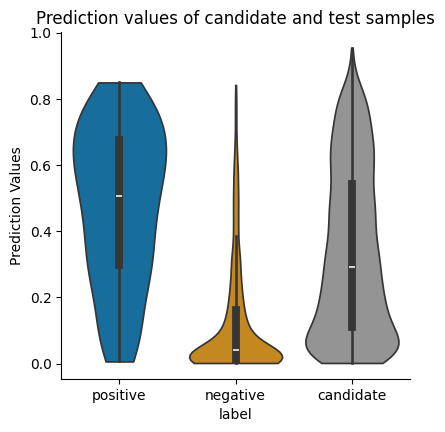

In [7]:
plt.figure(figsize=(4.5, 4.5))
test_and_candidate_set = predictions[(predictions['label'] == 'candidate') | (predictions['group_split_0'] == 'test')].copy()
sns.violinplot(test_and_candidate_set, x='label', order=['1.0', '0.0', 'candidate'], y='transfactor_ensemble', hue='label', hue_order=['0.0', '1.0', 'candidate'], cut=0, 
               palette={'0.0': sns.color_palette('colorblind')[1], '1.0': sns.color_palette('colorblind')[0], 'candidate': sns.color_palette('colorblind')[7]})
sns.despine()
plt.title('Prediction values of candidate and test samples')
plt.xlabel('label')
plt.xticks(ticks=[0, 1, 2], labels=['positive', 'negative', 'candidate'])
plt.ylabel('Prediction Values')
plt.savefig('pred_distribution.pdf', bbox_inches='tight')
plt.show()

### Metrics

In [8]:
results = []
for modality in ['transfactor', 'ablation', 'svm_rbf', 'svm_lin', 'cnn_lstm']:
    for i in list(range(5)) + ['ensemble']:
        config = f'{modality}_{i}'
        result = {'config': config,
              'split': i,
              'ensemble': i == 'ensemble',
              'modality': modality,
             }
        # Without candidates
        prediction_subset = predictions[predictions['label'].isin(['1.0', '0.0'])]
        test_subset = prediction_subset[prediction_subset['group_split_0'] == 'test'].copy()
        result.update({
                  f'auc': roc_auc_score(test_subset['label'] == '1.0', test_subset[config]),
                  f'aps': average_precision_score(test_subset['label'] == '1.0', test_subset[config]),
                 })

        
        for K in Ks:
            test_subset_top_k = test_subset.loc[test_subset[config].nlargest(K).index]
            result.update({f'P@{K}': precision_score(test_subset_top_k['label'] == '1.0', np.ones_like(test_subset_top_k[config]))})
        
        
        precision_at_K = []
        for K in range(len(test_subset)):
            test_subset_top_k = test_subset.loc[test_subset[config].nlargest(K).index]
            precision_at_K.append(precision_score(test_subset_top_k['label'] == '1.0', np.ones_like(test_subset_top_k[config])))
        result.update({f'P@K': precision_at_K})

        # ideal threshold
        if i == 'ensemble':
            val_subset = prediction_subset[prediction_subset[f'group_split_0'].isin(['train', 'val'])].copy()
        else:
            val_subset = prediction_subset[prediction_subset[f'group_split_{i}'] == 'val'].copy()
        precision, recall, thresholds = precision_recall_curve(val_subset['label'] == '1.0', val_subset[f'{modality}_ensemble'])
        f1_scores = 2*precision*recall / (precision+recall)
        best_threshold = thresholds[f1_scores.argmax()]

        result.update({
                  f'precision': precision_score(test_subset['label'] == '1.0', test_subset[config] > best_threshold, ),
                  f'recall': recall_score(test_subset['label'] == '1.0', test_subset[config] > best_threshold, ),
                  f'f1': f1_score(test_subset['label'] == '1.0', test_subset[config] > best_threshold, ),
                  f'ideal_threshold': best_threshold,
                 })
        results.append(result)

results = pd.DataFrame(results)

/ictstr01/groups/imm01/workspace/yang/miniconda3/envs/ghost_lustre/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/ictstr01/groups/imm01/workspace/yang/miniconda3/envs/ghost_lustre/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/ictstr01/groups/imm01/workspace/yang/miniconda3/envs/ghost_lustre/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to c

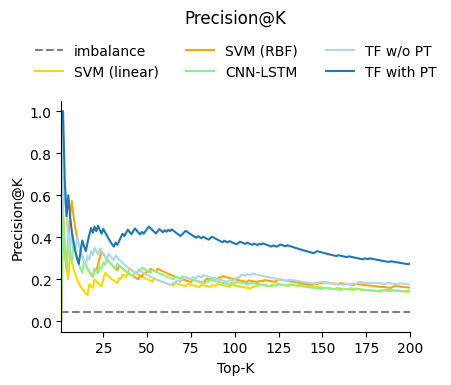

In [9]:
ensemble_results = results[results['config'].str.contains('ensemble')]

model_colors = {'svm_lin': 'gold', 'svm_rbf': 'orange', 'cnn_lstm': 'lightgreen', 'ablation': 'lightblue', 'transfactor': sns.color_palette('tab10')[0]}
model_name = {'svm_lin': 'SVM (linear)', 'svm_rbf': 'SVM (RBF)', 'cnn_lstm': 'CNN-LSTM', 'ablation': 'TF w/o PT', 'transfactor': 'TF with PT'}

plt.figure(figsize=(4.5, 3))
plt.axhline(imbalance, label='imbalance', c='grey', ls='--')
for model in model_colors.keys():
    sns.lineplot(x=range(len(test_subset)), y=ensemble_results[ensemble_results['modality'] == model]['P@K'].item(), label=model_name[model], color=model_colors[model])

# plt.xscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncols=3, frameon=False)
plt.ylabel('Precision@K')
plt.xlabel('Top-K')
plt.xlim(1, 200)
plt.title('Precision@K', y=1.3)
sns.despine()
plt.savefig('Precision@200.pdf', bbox_inches='tight')
plt.show()

In [10]:
results_ensemble = results[results['ensemble']].copy()
results_ensemble = results_ensemble[['config'] + [f'{metric}' for metric in ['auc', 'aps', 'f1', 'precision', 'recall', 'ideal_threshold']]]
results_ensemble

,config,auc,aps,f1,precision,recall,ideal_threshold
5,transfactor_ensemble,0.885561,0.298761,0.379032,0.335714,0.435185,0.571461
11,ablation_ensemble,0.792792,0.163313,0.225352,0.181818,0.296296,0.478289
17,svm_rbf_ensemble,0.742953,0.142937,0.214592,0.200000,0.231481,0.145732
23,svm_lin_ensemble,0.665393,0.113045,0.156863,0.166667,0.148148,0.126430
29,cnn_lstm_ensemble,0.780438,0.143113,0.208791,0.148438,0.351852,0.603605


In [11]:
results_ensemble = results[results['ensemble']].copy()
results_ensemble = results_ensemble[['config'] + [f'P@{K}' for K in Ks]]
results_ensemble

,config,P@50,P@100,P@200
5,transfactor_ensemble,0.44,0.37,0.275
11,ablation_ensemble,0.22,0.20,0.175
17,svm_rbf_ensemble,0.24,0.20,0.160
23,svm_lin_ensemble,0.20,0.17,0.140
29,cnn_lstm_ensemble,0.24,0.18,0.145


In [13]:
cols = [f'{metric}' for metric in ['auc', 'aps', 'precision', 'recall', 'f1']]
cols += ['ideal_threshold']
cols += [f'P@{K}' for K in [50, 100, 200]]
results_without_ensemble = results[~results['ensemble']].copy()
results_without_ensemble = results_without_ensemble.melt(id_vars=['modality'], value_vars=cols)

In [14]:
results_without_ensemble.groupby(['modality', 'variable']).describe()['value'][['mean', 'std']].apply(lambda x: f"{x['mean']:.2f}±{x['std']:.2f}", axis=1).to_frame().reset_index().rename(columns={0: 'value'})\
.pivot(index='modality', columns='variable', values='value')[['auc', 'aps', 'f1', 'precision', 'recall', 'ideal_threshold']]

variable,auc,aps,f1,precision,recall,ideal_threshold
modality,,,,,,
ablation,0.78±0.01,0.14±0.02,0.15±0.06,0.17±0.07,0.37±0.29,0.44±0.06
cnn_lstm,0.77±0.00,0.13±0.01,0.14±0.09,0.12±0.09,0.38±0.33,0.68±0.17
svm_lin,0.65±0.01,0.10±0.01,0.15±0.04,0.16±0.05,0.15±0.07,0.13±0.01
svm_rbf,0.74±0.01,0.13±0.02,0.19±0.03,0.19±0.02,0.20±0.06,0.16±0.01
transfactor,0.87±0.01,0.27±0.01,0.25±0.12,0.40±0.34,0.39±0.27,0.57±0.04


In [15]:
# Precision @ K
results_without_ensemble.groupby(['modality', 'variable']).describe()['value'][['mean', 'std']].apply(lambda x: f"{x['mean']:.2f}±{x['std']:.2f}", axis=1).to_frame().reset_index().rename(columns={0: 'value'})\
.pivot(index='modality', columns='variable', values='value')[[f'P@{K}' for K in Ks]]

variable,P@50,P@100,P@200
modality,,,
ablation,0.20±0.05,0.16±0.04,0.15±0.02
cnn_lstm,0.18±0.08,0.16±0.02,0.14±0.01
svm_lin,0.18±0.05,0.15±0.03,0.13±0.01
svm_rbf,0.20±0.03,0.19±0.01,0.15±0.01
transfactor,0.37±0.03,0.32±0.02,0.26±0.01


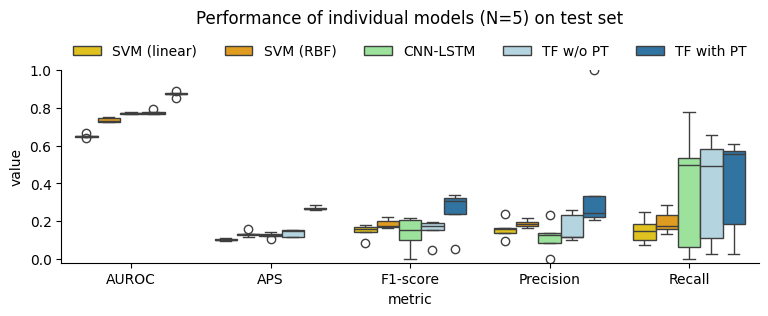

In [16]:
plt.figure(figsize=(9, 2.5))
results_without_ensemble = results[~results['ensemble']].copy()
# for metric in ['f1', 'recall', 'precision']:
#     results_without_ensemble.loc[results_without_ensemble['config'].str.contains('svm|rbf'), f'{metric}'] = results_without_ensemble.loc[results_without_ensemble['config'].str.contains('svm'), f'{metric}_ideal']

results_without_ensemble = results_without_ensemble.melt(id_vars=['modality'], value_vars=[f'{metric}' for metric in ['auc', 'aps', 'f1', 'precision', 'recall']])
results_without_ensemble['metric'] = results_without_ensemble['variable'].str.replace(f'', '').replace({'auc': 'AUROC', 'aps': 'APS', 'f1': 'F1-score', 'precision': 'Precision', 'recall': 'Recall'})
results_without_ensemble['model'] = results_without_ensemble['modality'].replace({'ablation': 'TF w/o PT', 'cnn_lstm': 'CNN-LSTM', 'transfactor': 'TF with PT', 'svm_lin': 'SVM (linear)', 'svm_rbf': 'SVM (RBF)'})
ax = sns.boxplot(results_without_ensemble,
                x='metric', #order=['random', 'TF w/o pretraining', 'TF with pretraining'], 
                y='value', 
                hue='model', hue_order=['SVM (linear)', 'SVM (RBF)', 'CNN-LSTM', 'TF w/o PT', 'TF with PT'], 
                palette={'random': 'lightgrey', 'TF w/o PT': 'lightblue', 'TF with PT': sns.color_palette('tab10')[0], 'SVM (linear)': 'gold', 'SVM (RBF)': 'orange', 'CNN-LSTM': 'lightgreen',},
                )
sns.move_legend(ax, 'upper center', ncols=5, bbox_to_anchor=(0.5, 1.2), frameon=False, title='')
plt.ylim(-0.02, 1)
sns.despine()
plt.title(f'Performance of individual models (N=5) on test set', y=1.2)
plt.savefig('benchmark_ideal.pdf', bbox_inches='tight')
plt.show()